In [0]:
# sandbox = 
DATA_PATH = "/content/drive/My Drive/DS/"

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.2.1-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
# Montamos el drive en /content/drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Cargamos librerías
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [0]:
# Creamos SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
# Importamos funciones que nos interesan de PySpark
from pyspark.sql import functions as F
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics



# Workshop de Spark

Cargamos un dataset con información de una campaña de marketing portuguesa para la venta de un préstamo bancario. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.



## Lectura de datos

In [0]:
bank_df = spark.read.csv(DATA_PATH+'/bank-full.csv', header=True, sep=';', inferSchema=True)

In [8]:
bank_df.show(3)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|picked_up_call|extra_info|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown| no|             1|         1|
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|2008|     151|       1|   -1|       0| unknown| no|             1|         1|
| 33|entrepreneur|married|secondary|     no|      2|    yes| yes|unknown|  5|  may|2008|      76|       1|   -1|       0| unknown| no|             1|         1|
+---+------------+-------+--------

### Comprobar correcta lectura de los datos

Comprobamos dimensiones del dataframe

In [9]:
dim_bankdf = (bank_df.count(), len(bank_df.columns))
dim_bankdf

(45211, 20)

Con un printSchema vemos la estructura

In [10]:
bank_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- picked_up_call: integer (nullable = true)
 |-- extra_info: integer (nullable = true)



In [0]:
for col in bank_df.columns:
    bank_df = bank_df.withColumnRenamed(col, col.replace('.','_').replace(' ','').lower())

In [12]:
bank_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- picked_up_call: integer (nullable = true)
 |-- extra_info: integer (nullable = true)



Sacamos a una variable los tipos de las columnas

In [13]:
bank_types = bank_df.dtypes
bank_types

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('year', 'int'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('y', 'string'),
 ('picked_up_call', 'int'),
 ('extra_info', 'int')]

Comprobamos si hay registros duplicados.

In [0]:
bank_df = bank_df.dropDuplicates()

In [15]:
(bank_df.count(), len(bank_df.columns))

(45211, 20)

Vemos que no ha eliminado ningún registro por duplicidad. Pasamos a estudiar los nulos

In [0]:
nulls = [(x, bank_df.filter(F.col(x).isNull()).count()) for x in bank_df.columns]

In [17]:
nulls

[('age', 0),
 ('job', 0),
 ('marital', 0),
 ('education', 0),
 ('default', 0),
 ('balance', 0),
 ('housing', 0),
 ('loan', 0),
 ('contact', 0),
 ('day', 0),
 ('month', 0),
 ('year', 0),
 ('duration', 0),
 ('campaign', 0),
 ('pdays', 0),
 ('previous', 0),
 ('poutcome', 0),
 ('y', 0),
 ('picked_up_call', 0),
 ('extra_info', 45133)]

Vemos que la columna extra_info tiene todos los valores nulos, por lo que no aporta al modelo. **La eliminamos**

In [0]:
bank_df = bank_df.drop('extra_info')

In [19]:
bank_df.dtypes # Comprobamos que la ha eliminado

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('year', 'int'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('y', 'string'),
 ('picked_up_call', 'int')]

Revisamos las variables que puedan tener más de un 90% de valores repetidos

In [0]:
rep_count = []
for col in bank_df.columns:
  value = bank_df.groupBy(col).agg(F.count(col).alias('counting')).orderBy(F.col('counting').desc()).first()
  num_labels = bank_df.groupBy(col).agg(F.count(col).alias('counting')).orderBy(F.col('counting').desc()).count()
  most_rep = value[0]
  count_most_rep = round((100*value[1]/dim_bankdf[0]),2)
  rep_count.append((col, num_labels, most_rep, count_most_rep))
  

In [21]:
rep_count

[('age', 77, 32, 4.61),
 ('job', 12, 'blue-collar', 21.53),
 ('marital', 3, 'married', 60.19),
 ('education', 4, 'secondary', 51.32),
 ('default', 2, 'no', 98.2),
 ('balance', 7168, 0, 7.77),
 ('housing', 2, 'yes', 55.58),
 ('loan', 2, 'no', 83.98),
 ('contact', 3, 'cellular', 64.77),
 ('day', 31, 20, 6.09),
 ('month', 12, 'may', 30.45),
 ('year', 3, 2008, 61.33),
 ('duration', 1573, 124, 0.42),
 ('campaign', 48, 1, 38.8),
 ('pdays', 559, -1, 81.74),
 ('previous', 41, 0, 81.74),
 ('poutcome', 4, 'unknown', 81.75),
 ('y', 2, 'no', 88.3),
 ('picked_up_call', 2, 1, 99.99)]

Aunque la variable y tenga una concentración de respuestas de 88% en el mismo sentido, la conservamos al reflejar la tasa de éxito.

---



 Obtenemos las columnas en las que el porcentaje de repetidos es superior al 90%  (ya sabemos que y está excluída)

In [22]:
drop_repeated = [x[0] for x in rep_count if x[-1] >= 90.0]
drop_repeated

['default', 'picked_up_call']

Una vez obtenida la lista, la pasamos para eliminar cada una de las columnas de la lista

In [23]:
for cols in drop_repeated:
  bank_df = bank_df.drop(cols)
bank_df.columns
# Comprobamos

['age',
 'job',
 'marital',
 'education',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'year',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'y']

In [24]:
len(bank_df.columns)

17

In [25]:
# Obtenemos lista de variables categóricas
categorical = [col for col,type in bank_types if type == 'string']
categorical

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'y']

In [26]:
# Obtenemos lista de variables numéricas
numerical = [col for col, type in bank_types if type != 'string']
numerical

['age',
 'balance',
 'day',
 'year',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'picked_up_call',
 'extra_info']

Una vez identificadas las variables categóricas y las numéricas por separado, pasamos a revisar la adecuación del tipo de dato. 
Aquí observamos que por la gran diversidad de valores en algunas variables, consideramos aconsejable tramear los valores de, por ejemplo, la variable age.

In [0]:
bank_df = bank_df.withColumn('age_range', 
                              F.when(F.col('age') <= 20, ' < 20')\
                               .when((F.col('age') > 20) & (F.col('age') <= 30), '21-30')\
                               .when((F.col('age') > 30) & (F.col('age') <= 40), '31-40')\
                               .when((F.col('age') > 40) & (F.col('age') <= 50), '41-50')\
                               .when((F.col('age') > 50) & (F.col('age') <= 60), '51-60')\
                               .otherwise('>60'))
# Se tramean por periodos de 10 años y se reflejan los valores destino en una nueva variable denominada 'age_range'

In [28]:
bank_df.show(3) # Mostramos la salida para comprobar

+---+----------+-------+---------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+---------+
|age|       job|marital|education|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|age_range|
+---+----------+-------+---------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+---------+
| 47|technician|married|  unknown|   2106|    yes|  no|unknown|  6|  may|2008|     168|       1|   -1|       0| unknown| no|    41-50|
| 30|technician| single|  unknown|    -48|    yes|  no|unknown|  6|  may|2008|     152|       2|   -1|       0| unknown| no|    21-30|
| 34|management| single| tertiary|    872|    yes|  no|unknown|  7|  may|2008|     105|       2|   -1|       0| unknown| no|    31-40|
+---+----------+-------+---------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+---------+
only showing top 3 rows



In [0]:
# Actualizamos las variables con nombres de columnas para excluir las que se han eliminado
bank_types = bank_df.dtypes
categorical = [col for col,type in bank_types if type == 'string']
numerical = [col for col, type in bank_types if type != 'string']

# ***Pasamos a analizar outliers en las variables numéricas***

In [0]:
# Obtenemos las operaciones a aplicar
avgs = [F.avg(col).alias('avg_' + col) for col in numerical]
maxs = [F.max(col).alias('max_' + col) for col in numerical]
mins = [F.min(col).alias('min_' + col) for col in numerical]
stds = [F.stddev(col).alias('std_' + col) for col in numerical]
operations = avgs + stds + maxs + mins 
operations
results = bank_df.select(operations).first()


In [31]:
# Aplicamos las operaciones anteriormente definidas para obtener los resultados
for col in numerical:
   
   avg = results['avg_' + col]
   std = results['std_' + col]
   maxi = results['max_' + col]
   mini = results['min_' + col]
   print('{}: avg={}, std={}, min={}, max={}'.format(col, round(avg, 2), round(std, 2), mini, maxi))

age: avg=40.94, std=10.62, min=18, max=95
balance: avg=1362.27, std=3044.77, min=-8019, max=102127
day: avg=15.81, std=8.32, min=1, max=31
year: avg=2008.44, std=0.6, min=2008, max=2010
duration: avg=258.16, std=257.53, min=0, max=4918
campaign: avg=2.76, std=3.1, min=1, max=63
pdays: avg=40.2, std=100.13, min=-1, max=871
previous: avg=0.58, std=2.3, min=0, max=275


In [32]:
# Calculamos los cuantiles y mediana
medians = {}
for x in numerical:
   medians[x] = bank_df.approxQuantile(x, [0.25, 0.5, 0.75, 0.90, 0.98], relativeError=0.01)
medians


{'age': [33.0, 39.0, 49.0, 56.0, 62.0],
 'balance': [71.0, 500.0, 1610.0, 3468.0, 8266.0],
 'campaign': [1.0, 2.0, 3.0, 6.0, 14.0],
 'day': [9.0, 16.0, 22.0, 28.0, 31.0],
 'duration': [103.0, 184.0, 336.0, 564.0, 930.0],
 'pdays': [-1.0, -1.0, -1.0, 183.0, 355.0],
 'previous': [0.0, 0.0, 0.0, 2.0, 6.0],
 'year': [2008.0, 2008.0, 2009.0, 2009.0, 2010.0]}

In [0]:
# Definimos función para evaluar con test de Tukey, generando una variable derivada con prefijo Outlier_ para cada numérica
def tukey_outliers(df, col):
    """
    Returns a new dataframe with outliers removed on column 'col' usting Tukey test
    """
    
    q1, q3 = df.approxQuantile(col, [0.25, 0.75], 0.01)
    IQR = q3 - q1
    
    min_thresh = q1 - 3 * IQR
    max_thresh = q3 + 3 * IQR
    
    df_no_outliers = df.withColumn('Outlier_'+ col, F.when(F.col(col).between(min_thresh, max_thresh), 'no').otherwise('yes'))
    
    return df_no_outliers

In [0]:
# Aplicamos la función anterior para marcar del DataFrame los outliers
 for cols in numerical:
  bank_df = tukey_outliers(bank_df, cols)

In [35]:
bank_df.show(3)

+---+----------+-------+---------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+---------+-----------+---------------+-----------+------------+----------------+----------------+-------------+----------------+
|age|       job|marital|education|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|age_range|Outlier_age|Outlier_balance|Outlier_day|Outlier_year|Outlier_duration|Outlier_campaign|Outlier_pdays|Outlier_previous|
+---+----------+-------+---------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+---------+-----------+---------------+-----------+------------+----------------+----------------+-------------+----------------+
| 47|technician|married|  unknown|   2106|    yes|  no|unknown|  6|  may|2008|     168|       1|   -1|       0| unknown| no|    41-50|         no|             no|         no|          no|              no|              no|           no|      

In [36]:
# Sacamos a una lista (para poder filtrar posteriormente) tanto las nuevas variables Outlier_ como la dependiente y
vbles_outlier = [cols for cols in bank_df.columns if 'Outlier_' in cols or cols == 'y']
vbles_outlier

['y',
 'Outlier_age',
 'Outlier_balance',
 'Outlier_day',
 'Outlier_year',
 'Outlier_duration',
 'Outlier_campaign',
 'Outlier_pdays',
 'Outlier_previous']

In [37]:
# Sacamos la relación entre variable de respuesta y la dependiente
for col in bank_df[vbles_outlier]:
  bank_df[vbles_outlier].groupBy('y', col).count().show()


+---+---+-----+
|  y|  y|count|
+---+---+-----+
| no| no|39922|
|yes|yes| 5289|
+---+---+-----+

+---+-----------+-----+
|  y|Outlier_age|count|
+---+-----------+-----+
| no|         no|39922|
|yes|         no| 5289|
+---+-----------+-----+

+---+---------------+-----+
|  y|Outlier_balance|count|
+---+---------------+-----+
| no|             no|37836|
| no|            yes| 2086|
|yes|            yes|  371|
|yes|             no| 4918|
+---+---------------+-----+

+---+-----------+-----+
|  y|Outlier_day|count|
+---+-----------+-----+
| no|         no|39922|
|yes|         no| 5289|
+---+-----------+-----+

+---+------------+-----+
|  y|Outlier_year|count|
+---+------------+-----+
| no|          no|39922|
|yes|          no| 5289|
+---+------------+-----+

+---+----------------+-----+
|  y|Outlier_duration|count|
+---+----------------+-----+
| no|              no|39543|
| no|             yes|  379|
|yes|             yes|  568|
|yes|              no| 4721|
+---+----------------+-----+

+---

Con estos datos podemos ver que los valores que el test de tuckey marca como posibles outlier, no se comportan siguiendo una distribución normal pero no podemos decir que sean outlier, sino valores que tienen otro comportamiento. Por tanto, no eliminamos ningún valor.

## **Analizamos los valores de las variables categóricas**

In [38]:
# Evaluamos para cada variable categórica qué valores tienen mayor porcentaje de éxito
for cols in categorical:
 df1 = bank_df.filter(F.col('duration') != 0).groupBy(cols).count().withColumnRenamed('count','total')
 bank_job_y_df = bank_df.filter(F.col('duration') != 0).groupBy(cols,'y').count().sort(F.col(cols).desc())
 df2=bank_job_y_df.join(df1, on=cols, how='inner').withColumn('porcentaje', F.round(F.col('count') / F.col('total') * 100,2)).sort(F.col('porcentaje').desc()).filter(F.col('y') == 'yes')
 df2.show(3)

+----------+---+-----+-----+----------+
|       job|  y|count|total|porcentaje|
+----------+---+-----+-----+----------+
|   student|yes|  269|  938|     28.68|
|   retired|yes|  516| 2264|     22.79|
|unemployed|yes|  202| 1303|      15.5|
+----------+---+-----+-----+----------+
only showing top 3 rows

+--------+---+-----+-----+----------+
| marital|  y|count|total|porcentaje|
+--------+---+-----+-----+----------+
|  single|yes| 1912|12790|     14.95|
|divorced|yes|  622| 5207|     11.95|
| married|yes| 2755|27211|     10.12|
+--------+---+-----+-----+----------+

+---------+---+-----+-----+----------+
|education|  y|count|total|porcentaje|
+---------+---+-----+-----+----------+
| tertiary|yes| 1996|13301|     15.01|
|  unknown|yes|  252| 1857|     13.57|
|secondary|yes| 2450|23200|     10.56|
+---------+---+-----+-----+----------+
only showing top 3 rows

+-------+---+-----+-----+----------+
|housing|  y|count|total|porcentaje|
+-------+---+-----+-----+----------+
|     no|yes| 3354|

+-------------+---+-----+-----+----------+
|          job|  y|count|total|porcentaje|
+-------------+---+-----+-----+----------+
|      student|yes|  269|  938|     28.68|
|      retired|yes|  516| 2264|     22.79|
|   unemployed|yes|  202| 1303|      15.5|
|   management|yes| 1301| 9457|     13.76|
|       admin.|yes|  631| 5171|      12.2|
|self-employed|yes|  187| 1579|     11.84|
|      unknown|yes|   34|  288|     11.81|
|   technician|yes|  840| 7596|     11.06|
|     services|yes|  369| 4154|      8.88|
|    housemaid|yes|  109| 1240|      8.79|
| entrepreneur|yes|  123| 1486|      8.28|
|  blue-collar|yes|  708| 9732|      7.27|
+-------------+---+-----+-----+----------+



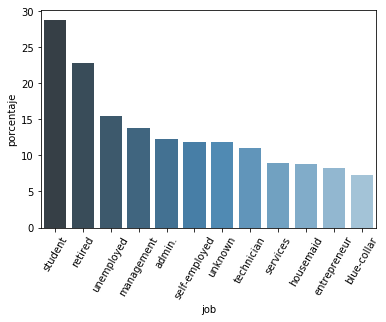

+--------+---+-----+-----+----------+
| marital|  y|count|total|porcentaje|
+--------+---+-----+-----+----------+
|  single|yes| 1912|12790|     14.95|
|divorced|yes|  622| 5207|     11.95|
| married|yes| 2755|27211|     10.12|
+--------+---+-----+-----+----------+



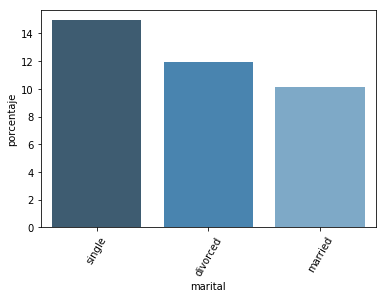

+---------+---+-----+-----+----------+
|education|  y|count|total|porcentaje|
+---------+---+-----+-----+----------+
| tertiary|yes| 1996|13301|     15.01|
|  unknown|yes|  252| 1857|     13.57|
|secondary|yes| 2450|23200|     10.56|
|  primary|yes|  591| 6850|      8.63|
+---------+---+-----+-----+----------+



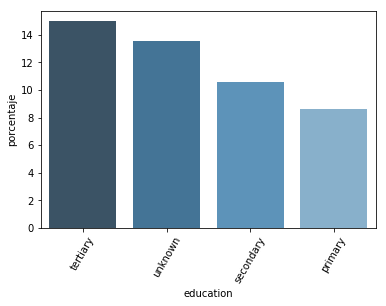

+-------+---+-----+-----+----------+
|housing|  y|count|total|porcentaje|
+-------+---+-----+-----+----------+
|     no|yes| 3354|20080|      16.7|
|    yes|yes| 1935|25128|       7.7|
+-------+---+-----+-----+----------+



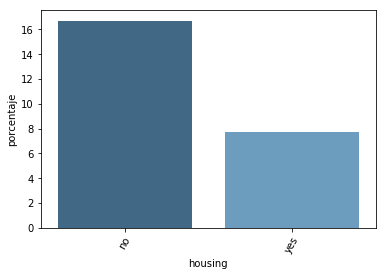

+----+---+-----+-----+----------+
|loan|  y|count|total|porcentaje|
+----+---+-----+-----+----------+
|  no|yes| 4805|37965|     12.66|
| yes|yes|  484| 7243|      6.68|
+----+---+-----+-----+----------+



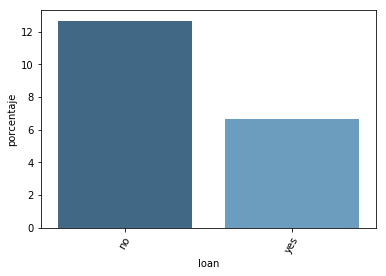

+---------+---+-----+-----+----------+
|  contact|  y|count|total|porcentaje|
+---------+---+-----+-----+----------+
| cellular|yes| 4369|29283|     14.92|
|telephone|yes|  390| 2906|     13.42|
|  unknown|yes|  530|13019|      4.07|
+---------+---+-----+-----+----------+



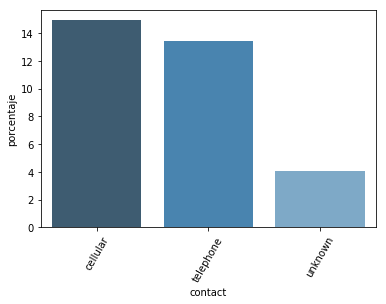

+-----+---+-----+-----+----------+
|month|  y|count|total|porcentaje|
+-----+---+-----+-----+----------+
|  mar|yes|  248|  477|     51.99|
|  dec|yes|  100|  214|     46.73|
|  sep|yes|  269|  579|     46.46|
|  oct|yes|  323|  738|     43.77|
|  apr|yes|  577| 2932|     19.68|
|  feb|yes|  441| 2649|     16.65|
|  aug|yes|  688| 6246|     11.02|
|  jun|yes|  546| 5341|     10.22|
|  nov|yes|  403| 3970|     10.15|
|  jan|yes|  142| 1403|     10.12|
|  jul|yes|  627| 6895|      9.09|
|  may|yes|  925|13764|      6.72|
+-----+---+-----+-----+----------+



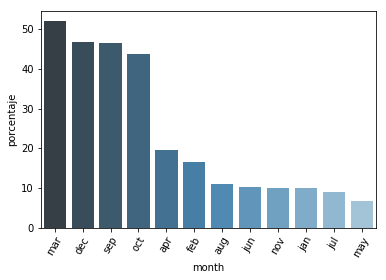

+--------+---+-----+-----+----------+
|poutcome|  y|count|total|porcentaje|
+--------+---+-----+-----+----------+
| success|yes|  978| 1511|     64.73|
|   other|yes|  307| 1840|     16.68|
| failure|yes|  618| 4901|     12.61|
| unknown|yes| 3386|36956|      9.16|
+--------+---+-----+-----+----------+



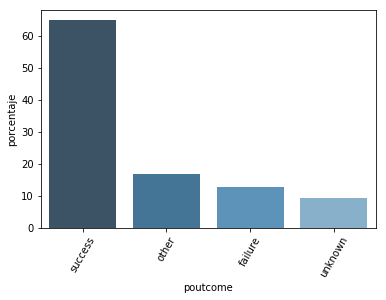

+---+-----+-----+----------+
|  y|count|total|porcentaje|
+---+-----+-----+----------+
|yes| 5289| 5289|     100.0|
+---+-----+-----+----------+



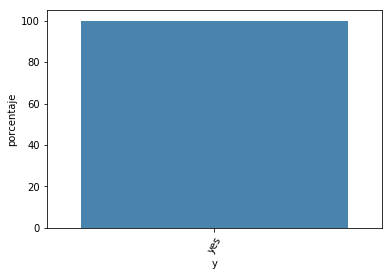

+---------+---+-----+-----+----------+
|age_range|  y|count|total|porcentaje|
+---------+---+-----+-----+----------+
|      >60|yes|  502| 1188|     42.26|
|     < 20|yes|   33|   97|     34.02|
|    21-30|yes| 1112| 6933|     16.04|
|    31-40|yes| 1812|17685|     10.25|
|    51-60|yes|  811| 8066|     10.05|
|    41-50|yes| 1019|11239|      9.07|
+---------+---+-----+-----+----------+



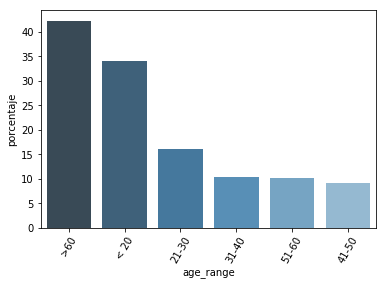

In [39]:
for cols in categorical:
 df1 = bank_df.filter(F.col('duration') != 0).groupBy(cols).count().withColumnRenamed('count','total')
 bank_job_y_df = bank_df.filter(F.col('duration') != 0).groupBy(cols,'y').count().sort(F.col(cols).desc())
 df2=bank_job_y_df.join(df1, on=cols, how='inner').withColumn('porcentaje', F.round(F.col('count') / F.col('total') * 100,2)).sort(F.col('porcentaje').desc()).filter(F.col('y') == 'yes')
 df_ = df2.toPandas()
 sns.barplot(x=cols, y='porcentaje', data=df_, palette="Blues_d")
 df2.show()
 plt.xticks(rotation=60)
 plt.show()

### **Conclusiones: **

Estudiamos el porcentaje de éxito de contratación para cada variable cualitativa. 
Sacamos insights interesantes:
**Jobs de más éxito**: student (28.68%) y retired (22.79%) 
**Marital de más éxito**: single (14.95%)
**Education**: tertiary (15.01%)
**Default**: no (11.8%)
**Housing**: no (16.7%)
**Loan**: no (12.66%)
**Month**: mar, dec, sep & oct: >40%
**poutcome**: success 64.7%


## ***Matriz de correlación***

In [40]:
# Creamos nueva variable y_int con valores 1 si hay éxito o un 0 si no lo hay
bank_df = bank_df.withColumn('y_int', 
                            F.when(F.col('y') == 'yes', 1)\
                            .otherwise(0))
bank_df.show(3)

+---+----------+-------+---------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+---------+-----------+---------------+-----------+------------+----------------+----------------+-------------+----------------+-----+
|age|       job|marital|education|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|age_range|Outlier_age|Outlier_balance|Outlier_day|Outlier_year|Outlier_duration|Outlier_campaign|Outlier_pdays|Outlier_previous|y_int|
+---+----------+-------+---------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+---------+-----------+---------------+-----------+------------+----------------+----------------+-------------+----------------+-----+
| 47|technician|married|  unknown|   2106|    yes|  no|unknown|  6|  may|2008|     168|       1|   -1|       0| unknown| no|    41-50|         no|             no|         no|          no|              no|              no|  

In [41]:
# Actualizamos la lista numerical para recoger la nueva variable creada
numerical = [col for col, type in bank_df.dtypes if type != 'string']
numerical

['age',
 'balance',
 'day',
 'year',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'y_int']

In [42]:
# Análisis de correlación con la variable dependiente y_int y la pasamos a DF Pandas
results_corrs = bank_df.select([F.corr(F.col('y_int'), F.col(c)).alias(c) for c in numerical])
results_corrs.toPandas()

,age,balance,day,year,duration,campaign,pdays,previous,y_int
0,0.025155,0.052838,-0.028348,0.329994,0.394521,-0.073172,0.103621,0.093236,1.0


In [43]:
# La matriz de correlación general
corr_matrix = Statistics.corr(bank_df.select(numerical).rdd.map(lambda v: Vectors.dense(v)), method='pearson')
corr_matrix = pd.DataFrame(corr_matrix, columns=numerical, index=numerical)
corr_matrix

,age,balance,day,year,duration,campaign,pdays,previous,y_int
age,1.000000,0.097783,-0.009120,-0.008022,-0.004648,0.004760,-0.023758,0.001288,0.025155
balance,0.097783,1.000000,0.004503,0.031499,0.021560,-0.014578,0.003435,0.016674,0.052838
day,-0.009120,0.004503,1.000000,-0.170216,-0.030206,0.162490,-0.093044,-0.051710,-0.028348
year,-0.008022,0.031499,-0.170216,1.000000,0.037030,-0.166185,0.462736,0.293186,0.329994
duration,-0.004648,0.021560,-0.030206,0.037030,1.000000,-0.084570,-0.001565,0.001203,0.394521
campaign,0.004760,-0.014578,0.162490,-0.166185,-0.084570,1.000000,-0.088628,-0.032855,-0.073172
pdays,-0.023758,0.003435,-0.093044,0.462736,-0.001565,-0.088628,1.000000,0.454820,0.103621
previous,0.001288,0.016674,-0.051710,0.293186,0.001203,-0.032855,0.454820,1.000000,0.093236
y_int,0.025155,0.052838,-0.028348,0.329994,0.394521,-0.073172,0.103621,0.093236,1.000000


In [44]:
# Creamos una máscara para filtrar
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True,  True,  True],
       [False, False, False, False, False,  True,  True,  True,  True],
       [False, False, False, False, False, False,  True,  True,  True],
       [False, False, False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False, False, False,  True]])

In [45]:
# Aplicamos la máscara
corr_matrix = corr_matrix.mask(mask)
corr_matrix

,age,balance,day,year,duration,campaign,pdays,previous,y_int
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,0.097783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,-0.009120,0.004503,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,-0.008022,0.031499,-0.170216,NaN,NaN,NaN,NaN,NaN,NaN
duration,-0.004648,0.021560,-0.030206,0.037030,NaN,NaN,NaN,NaN,NaN
campaign,0.004760,-0.014578,0.162490,-0.166185,-0.084570,NaN,NaN,NaN,NaN
pdays,-0.023758,0.003435,-0.093044,0.462736,-0.001565,-0.088628,NaN,NaN,NaN
previous,0.001288,0.016674,-0.051710,0.293186,0.001203,-0.032855,0.454820,NaN,NaN
y_int,0.025155,0.052838,-0.028348,0.329994,0.394521,-0.073172,0.103621,0.093236,NaN


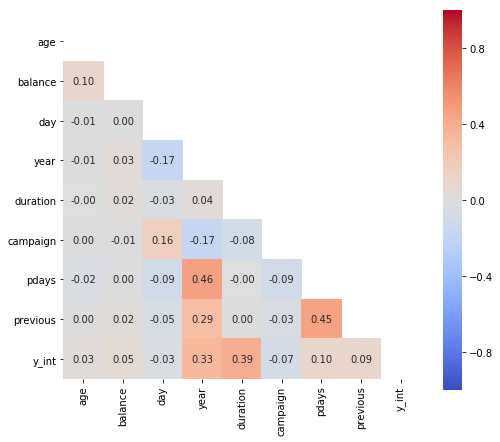

In [46]:
# Ploteamos la matriz 
# Ipython magic para plotear en el NB
%matplotlib inline 
plt.figure(figsize=(8,7))
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1, vmin=-1, square=True, annot=True, fmt='.2f')

**No hay correlaciones que resulten significativas para variables numéricas.**


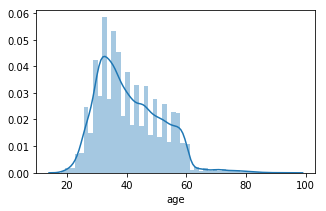

In [47]:
# Pasamos el DF entero a Pandas para poder plotear
bank_df_pd = bank_df.toPandas()
plt.figure(figsize=(5,3))
sns.distplot(bank_df_pd['age'], kde=True)
# Las llamadas se concentran en rango de 30-40 años

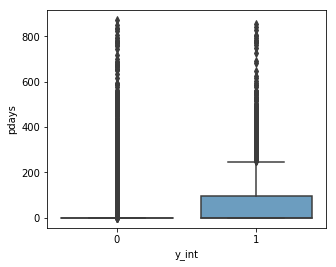

In [48]:
plt.figure(figsize=(5,4))
sns.boxplot(x='y_int', y='pdays', data=bank_df_pd, orient='v', palette="Blues_d")
# Vemos que los que han tenido contactos en días previos tienen más probabilidades de terminar contratando

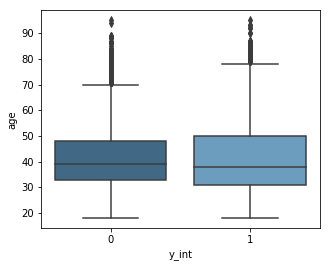

In [49]:
# Comparamos la contratación con la edad
plt.figure(figsize=(5,4))
sns.boxplot(x='y_int', y='age', data=bank_df_pd, orient='v', palette="Blues_d")